In [2]:

from typing import Sized
import warnings
import os
import torch
import torch.nn as nn
import json
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers import BertConfig, BertTokenizer
from transformers import  BertForMaskedLM
from tqdm import tqdm 
from torch.utils.data import TensorDataset, DataLoader, random_split 
from transformers import BertForSequenceClassification, AdamW 
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, RobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel, DebertaConfig, DebertaForSequenceClassification
from transformers import get_linear_schedule_with_warmup 

import copy
import numpy as np 
from transformers import BertTokenizer, BertModel
import torch
import pickle
import nltk
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.cuda()
load_model_path = '/data/zhanghData/AttentionDefense/save_models/imdb_bert/base/best.pt'
model.load_state_dict(torch.load(load_model_path))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [19]:
model_type = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_type)
roberta_config = RobertaConfig.from_pretrained(model_type, num_labels=2, output_attentions=False, output_hidden_states=False, \
                attention_probs_dropout_prob=0, hidden_dropout_prob=0.1)
roberta = RobertaForSequenceClassification.from_pretrained(model_type, config=roberta_config) 
roberta.cuda()
load_model_path = '/data/zhanghData/AttentionDefense/save_models/imdb_roberta/base/best.pt'
roberta.load_state_dict(torch.load(load_model_path))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

<All keys matched successfully>

In [20]:
def pre_tokenize(seq, tokenizer, use_MASK=False, mask_indices=[], max_length=0):
    seq = seq.replace('\n', '').lower()
    words = seq.split(' ') 
    if use_MASK:
        for idx in mask_indices:
            words[idx] = '[MASK]'
    sub_words =  []
    keys = []
    index = 0
    if max_length == 0:
        for word in words:
            sub = tokenizer.tokenize(word)
            sub_words += sub
            keys.append([index, index + len(sub)])
            index += len(sub)
    else:
        new_words =  []
        for word in words:
            sub = tokenizer.tokenize(word)
            if len(sub_words)+len(sub) > max_length-2:
                break
            new_words.append(word)
            sub_words += sub
            keys.append([index, index + len(sub)])
            index += len(sub)
        words = new_words

    if words[-1] =='':
        words = words[:-1]
        keys = keys[:-1]

    return words, sub_words, keys

In [21]:
from data_utils import get_pos_vocabulary, get_stopwords
pos_vocabulary = get_pos_vocabulary()
print(len(pos_vocabulary))
stop_words = get_stopwords()
#supported_pos_tags = get_supported_pos_tags()
supported_pos_tags = [#nltk词性标注中的一些类别
    #'CC',  # coordinating conjunction, like "and but neither versus whether yet so"  #并列连词
    'JJ',  # Adjective, like "second ill-mannered" #组合式形容词
    'JJR',  # Adjective, comparative, like "colder" #形容词比较级
    'JJS',  # Adjective, superlative, like "cheapest" 形容词最高级
    'NN',  # Noun, singular or mass #名词 单数
    'NNS',  # Noun, plural #名词复数
    'NNP',  # Proper noun, singular #专有名词单数
    'NNPS',  # Proper noun, plural  #专有名词复数
    'RB',  # Adverb#副词
    'RBR',  # Adverb, comparative, like "lower heavier"
    'RBS',  # Adverb, superlative, like "best biggest"
    'VB',  # Verb, base form
    'VBD',  # Verb, past tense 动词过去式
    'VBG',  # Verb, gerund or present participle 动名词/现在分词
    'VBN',  # Verb, past participle #过去分词
    'VBP',  # Verb, non-3rd person singular present #非第三人称单数
    'VBZ',  # Verb, 3rd person singular present #第三人称单数
]

28301


In [22]:
##攻击文件导入
from attack_instance import read_adv_files
atk_path = '/data/zhanghData/AttentionDefense/save_results/attacks/imdb_roberta/base/pwws_0.1_100.csv'
atk_instances = read_adv_files(atk_path)
# all_orig_texts = [atk.orig_text for atk in atk_instances]
# all_perd_texts = [atk.perd_text for atk in atk_instances]
# all_gold_labels = [atk.ground for atk in atk_instances]
# all_changed_indices = [atk.atk_indices for atk in atk_instances]
# all_change_words = [atk.atk_changes for atk in atk_instances] 

In [23]:
def valid_select(words,sorted_words_idxs,vocabulary,stopwords):
    candidates = [] 
    cand_indices  = []
    for idx in sorted_words_idxs:
        if words[idx] not in vocabulary:
            #print(f"{words[idx]} not in vocabulary")
            vocabulary[words[idx]] = nltk.pos_tag([words[idx]])[0][1]
        if vocabulary[words[idx]] in supported_pos_tags and words[idx] not in stopwords:
            candidates.append(words[idx])
            cand_indices.append(idx)
    return candidates, cand_indices

In [24]:
def sensitive_test(words,idx,maxlength,tokenizer,model,device):
    input_ids = tokenizer.encode(
                    " ".join(words[:idx]+'MASK'+words[idx+1:]),
                    truncation=True,                       
                    add_special_tokens = True,  # 添加special tokens， 也就是CLS和SEP
                    max_length = maxlength,           # 设定最大文本长度 200 for IMDb and 40 for sst
                    # pad_to_max_length = True,   # pad到最大的长度  
                    padding = 'max_length',
                    return_tensors = 'pt'       # 返回的类型为pytorch tensor
                )
    output = model(input_ids=input_ids.to(device), token_type_ids=None, \
                    attention_mask=(input_ids>0).to(device))
    label= torch.argmax(output.logits[0])
    return int(label)

In [25]:
def create_mask(words,cand_ids,tokenizer,maxlength):
    
    all_input_ids  = []
    for i in cand_ids:
        text = copy.deepcopy(words)
        text[i]='[MASK]'
        input_ids = tokenizer.encode(
                        " ".join(text),
                        truncation=True,                       
                        add_special_tokens = True,  # 添加special tokens， 也就是CLS和SEP
                        max_length = maxlength,           # 设定最大文本长度 200 for IMDb and 40 for sst
                        # pad_to_max_length = True,   # pad到最大的长度  
                        padding = 'max_length',
                        return_tensors = 'pt'       # 返回的类型为pytorch tensor
                    )
        all_input_ids.append(input_ids)    
    all_input_ids = torch.cat(all_input_ids, dim=0)
    return all_input_ids


In [26]:

def get_scores(output,re_outputs):
    scores = []
    label=torch.argmax(output)
    label=int(label)
    re_labels = torch.argmax(re_outputs)
    # print("---------In get scores---------")
    # print(f'label:{label}')
    # print(f"mask labels:{torch.argmax(re_outputs,dim=1)}")
    confidence = torch.nn.functional.softmax(re_outputs)
    #print(confidence)
    for prob in confidence:
        #scores.append(float(prob[int(label)]-prob[1-int(label)]))
        scores.append(float(output[label]-prob[label]))
    # print(scores)   
    # print("---------endIn get scores---------")
    return scores,label,re_labels
    #.detach().cpu().numpy()


In [30]:
def words_sensitivity(
    model,tokenizer, sentence,pos_vocabulary,stopwords,
    max_length=40,batch_size=8
    ):
    device = torch.device('cuda')
    model.eval()
    words,sub_words,keys = pre_tokenize(sentence, tokenizer, use_MASK=False, max_length=max_length)
    #print("words:{}".format(words))
    # print("keys:{}".format(keys))
    assert len(words) == len(keys)
    input_words = ['[CLS]'] + sub_words + ['[SEP]']
    input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(input_words)])
    assert len(sub_words) == (len(input_ids[0])-2)
    outputs = model(input_ids.to(device), token_type_ids=None, attention_mask=(input_ids>0).to(device))
    
    #获取有效词，即只测试文本对有效词变化的敏感程度
    candidates, cand_ids = valid_select(words,[i for i in range(len(words))],pos_vocabulary,stopwords)
    mask_copies_ids = create_mask(words, cand_ids, tokenizer,max_length)
    mask_dataloader = DataLoader(mask_copies_ids, batch_size = batch_size, shuffle = False)
    logits = []
    for i, batch in enumerate(mask_dataloader):
            with torch.no_grad():
                re_outputs = model(input_ids=batch.to(device), token_type_ids=None, \
                    attention_mask=(batch>0).to(device))
                logits.append(re_outputs.logits)
    logits = torch.cat(logits, dim=0)
                # if i == 0:
                #     logits = re_outputs.logits
                # else:
                #     logits.append(re_outputs.logits)
            
    #print(re_outputs)
    scores,pre_label,re_labels = get_scores(outputs.logits[0],logits)
    return  candidates,cand_ids,scores,pre_label,re_labels


In [32]:
def sentence_sensitivity(model,tokenizer, sentence, label, pos_vocabulary,stopwords,
    alpha=0.1, max_length=40,batch_size=8
    ):
    print("------In sentence sensitivity------")
    candidates,cand_ids,scores,pre_label,re_labels = words_sensitivity(
                model,tokenizer, sentence, pos_vocabulary,stopwords,
                max_length,batch_size)
    print( "label:{},pre_label:{}".format(label,pre_label))
    pre_acc_flag = 1 
    sens_flag = 0
    if label != pre_label:
        pre_acc_flag = 0
        return 0,0
        
    scores_labels_sorted_ = sorted(zip(scores,re_labels),key=lambda k:k[0], reverse=True)
    print(scores_labels_sorted_)
    if label != (sum(re_labels)/len(re_labels)>=0.5):
        sens_flag = 1 
    return pre_acc_flag,sens_flag


In [33]:
sens_count = 0
count = 0
for atk in atk_instances:
    #  self.suss = False
    # self.skip = False
    # self.fail = False
    #print(f"atk.perd_text[:-1]:{atk.perd_text[:-1]}")
    if atk.suss == True:
        count +=1
        print('--------------------------------------------------------------------')
        # print(atk.perd_text)
        # print(f"atk.atk_changes:{atk.atk_changes,atk.atk_indices}")

        # print(f"ture label:{atk.ground},attak label:{atk.perd_label}")
        pre_acc_flag,sens_flag = sentence_sensitivity\
                (model,tokenizer, atk.perd_text, atk.perd_label,pos_vocabulary,stopwords=stop_words,\
                alpha=0.1, max_length=200)
        
        # print("final important words and idx:{},{}".format(candidate,cand_idx))
        # print(f"true label:{atk.ground}")
        sens_count+=sens_flag
        
print("coount:{},sence_coount:{}".format(count,sens_count))
print("{:2f}%".format(sens_count/count*100))

--------------------------------------------------------------------
------In sentence sensitivity------


/home/zhangh/anaconda3/envs/defense/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


label:0,pre_label:1
error for predction!
--------------------------------------------------------------------
------In sentence sensitivity------
label:0,pre_label:1
error for predction!
--------------------------------------------------------------------
------In sentence sensitivity------
label:1,pre_label:0
error for predction!
--------------------------------------------------------------------
------In sentence sensitivity------
label:0,pre_label:1
error for predction!
--------------------------------------------------------------------
------In sentence sensitivity------
label:1,pre_label:0
error for predction!
--------------------------------------------------------------------
------In sentence sensitivity------
label:0,pre_label:0


TypeError: zip argument #2 must support iteration

In [ ]:
    # #scores=scores
    # attk_flag = 1
    # if pre_labbel != label:
    #     attk_flag = 0
    
    # assert len(words) == len(scores)
    # #print('------sorting------')
    # # for k,value in zip(words,scores):
    # #     print(f"({k},{value})")
    # sorted_words = sorted(zip(words, scores),key=lambda x:x[1], reverse=True)
    # #print(f"sorted_words:{sorted_words}")
    # sorted_ = sorted(enumerate(scores),key=lambda x:x[1], reverse=False)
    # sorted_words_idxs = [i[0] for i in sorted_]
    # candidates, cand_idx = valid_select(words,sorted_words_idxs,pos_vocabulary,stopwords)
    # #print("After valid:{}".format(candidates))
    # result_num = max(min(len(candidates),int(alpha*len(words))),1)
    
    # label_sensitive = sensitive_test(words,cand_idx[0],max_length,tokenizer,model,device)
    # sens_flag  = 0
    # if (pre_labbel!=label_sensitive):
    #     sens_flag =1
    # return candidates[:2], cand_idx[:2],sens_flag , attk_flag
    # #        sorted_subs = sorted(zip(all_subs_indices,all_sub_scores),key=lambda x:x[1], reverse=True)

In [1]:
count_change = 0
count_candidate = 0
count_recall = 0
#count_acc = 0
sens_count = 0
count = 0
suss_count = 0
attk_count = 0
for atk in atk_instances:
    #  self.suss = False
    # self.skip = False
    # self.fail = False
    #print(f"atk.perd_text[:-1]:{atk.perd_text[:-1]}")
    if atk.suss == True:
        count +=1
        print('--------------------------------------------------------------------')
        # print(atk.perd_text)
        # print(f"atk.atk_changes:{atk.atk_changes,atk.atk_indices}")

        # print(f"ture label:{atk.ground},attak label:{atk.perd_label}")
        candidate, cand_idx,sens_flag,attk_flag = get_importance_words\
                (model,tokenizer, atk.perd_text, atk.perd_label,pos_vocabulary,stopwords=stop_words,\
                alpha=0.1, max_length=200)
        
        # print("final important words and idx:{},{}".format(candidate,cand_idx))
        # print(f"true label:{atk.ground}")
        count_change += len(atk.atk_changes)
        count_candidate +=  len(candidate)
        recall = sum([ idx in cand_idx  for idx in atk.atk_indices])
        if recall == 0:
                
                print(atk.perd_text)
                print(f"atk.atk_changes:{atk.atk_changes,atk.atk_indices}")

                print(f"ture label:{atk.ground},attak label:{atk.perd_label}")
                print("final important words and idx:{},{}".format(candidate,cand_idx))
                print(f"true label:{atk.ground}")
        print(f"If sensitive:{sens_flag}")
        print(f"If attack always:{attk_flag}")
        if sens_flag==1 and attk_flag==1:
                suss_count +=1
        count_recall +=recall
        sens_count+=sens_flag
        attk_count += attk_flag
        
acc = count_recall/count_candidate
recall =count_recall/count_change
print("acc:{},recall:{}".format(acc,recall))
print(sens_count)
print(count)

NameError: name 'atk_instances' is not defined

In [37]:
x!

SyntaxError: invalid syntax (<ipython-input-37-e3ef757ecb7f>, line 1)

#### adversarial examples  softmax分布情况

In [13]:
def atk_logits(model,tokenizer):
        logits = []
        device = torch.device('cuda')
        model.eval()
        maxlength=40
        for atk in atk_instances:
        #  self.suss = False
        # self.skip = False
        # self.fail = False
                if atk.suss == True:
                        input_ids = tokenizer.encode(
                                atk.perd_text,
                                truncation=True,                       
                                add_special_tokens = True,  # 添加special tokens， 也就是CLS和SEP
                                max_length = maxlength,           # 设定最大文本长度 200 for IMDb and 40 for sst
                                # pad_to_max_length = True,   # pad到最大的长度  
                                padding = 'max_length',
                                return_tensors = 'pt'       # 返回的类型为pytorch tensor
                                )
                        output = model(input_ids=input_ids.to(device), token_type_ids=None, \
                                        attention_mask=(input_ids>0).to(device))
                        confidence = torch.nn.functional.softmax(output.logits[0])
                        logits.append(confidence.detach().cpu().numpy())
        return logits

In [27]:
logits = atk_logits(model,tokenizer)

/home/zhangh/anaconda3/envs/defense/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


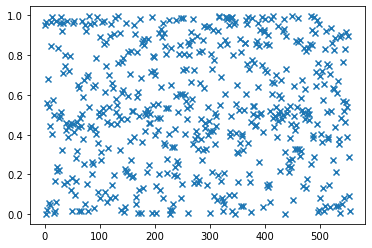

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 数据准备
N = 1000
y1 = np.array([logit[0] for logit in logits])
x = np.arange(len(y1)+1)[1:]
# 用Matplotlib画散点图
plt.scatter(x, y1,marker='x')
plt.show()


In [29]:
rob_logits = atk_logits(roberta, roberta_tokenizer)

/home/zhangh/anaconda3/envs/defense/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [42]:
rob_logits[1]

array([0.9098301 , 0.09016994], dtype=float32)

In [44]:
idx = 1
indices = []
for logit1,logit2 in zip(logits,rob_logits):
    #print(max(logit1),max(logit2))
    if np.argmax(logit1)==np.argmax(logit2):
        indices.append(idx)
    idx+=1


In [45]:
len(indices)


212

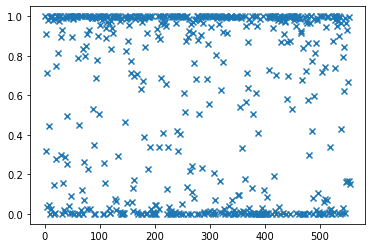

In [34]:

# 数据准备
N = 1000
y2 = np.array([logit[0] for logit in rob_logits])
x = np.arange(len(y2)+1)[1:]
# 用Matplotlib画散点图
plt.scatter(x, y2,marker='x')
plt.show()

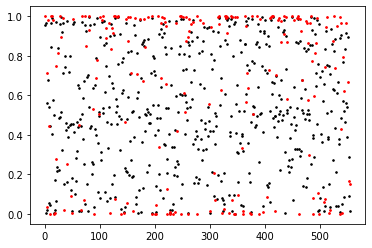

In [54]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
#data  = loadmat(r'C:\Users\Desktop\fourclass.mat')['data']
 # 创建画布
fig = plt.figure()
ax = fig.add_subplot(111)
p1 = ax.scatter(x, y1, marker='.', color='black', s=10)
#p2 = ax.scatter(x, y2, marker='.', color='green', s=8)
x3 = indices
y3 = [y2[idx-1] for idx in indices]
p3 = ax.scatter(x3, y3, marker='.', color='red', s=12)
plt.show()


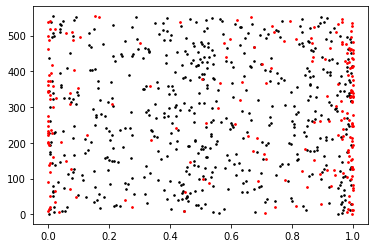

In [56]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
#data  = loadmat(r'C:\Users\Desktop\fourclass.mat')['data']
 # 创建画布
fig = plt.figure()
ax = fig.add_subplot(111)
p1 = ax.scatter(y1, x, marker='.', color='black', s=10)
#p2 = ax.scatter(x, y2, marker='.', color='green', s=8)
x3 = indices
y3 = [y2[idx-1] for idx in indices]
p3 = ax.scatter(y3, x3, marker='.', color='red', s=12)
plt.show()
